In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [1]:
import csv
import pandas as pd
from datetime import date,datetime
import io
import gcsfs
import os
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from datetime import datetime, timedelta
from prophet import Prophet
import numpy as np
import itertools
from prophet.diagnostics import cross_validation

import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/cloud/integration-gcp-c828c815-6c5a918e4371.json'
bqclient = bigquery.Client()

query_string = """
SELECT
checkpoint,count(distinct player_id) as count_players
FROM `vxp-looker-8c0a3516.PW_staging.player_checkpoint_live`
where VXP_client_id=1 
group by checkpoint
"""

PL_events= (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)
print(PL_events.count())

checkpoint       193
count_players    193
dtype: int64


In [2]:
PL_events["date"]=pd.to_datetime(PL_events['checkpoint'])
PL_events=PL_events.set_index('date').sort_index()


In [3]:
PL_events=PL_events[:-1]

<AxesSubplot:xlabel='date'>

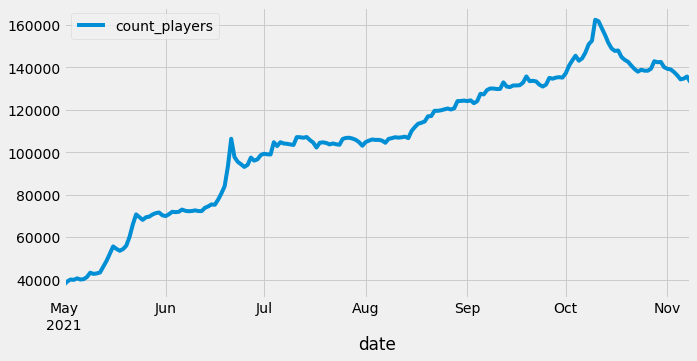

In [4]:
fig,ax=plt.subplots(1,figsize=(10,5))

PL_events.plot(ax=ax)


## Creating train and holdout set

In [5]:
hold_out_percentage=0.2
hold_out_size=round(hold_out_percentage * len(PL_events))

train=PL_events[:len(PL_events)- hold_out_size]
test=PL_events[len(PL_events)- hold_out_size:]

print(f"Train size is {len(train)}")
print(f"Test size is {len(test)}")
      

Train size is 154
Test size is 38


## Prophet Modeling

In [6]:
series=train.reset_index()[['date','count_players']]
series.columns=['ds','y']

In [8]:
print(len(series))

154


#### Basic Model

In [7]:
m1=Prophet()
m1.fit(series)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
train_ds=m1.make_future_dataframe(periods=0)

In [18]:
forecast=m1.predict(train_ds)

In [19]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-01,37204.981905,31788.234081,40814.624622,37204.981905,37204.981905,-899.040496,-899.040496,-899.040496,-899.040496,-899.040496,-899.040496,0.0,0.0,0.0,36305.941408
1,2021-05-02,38249.708569,35072.805590,44020.113587,38249.708569,38249.708569,1493.260827,1493.260827,1493.260827,1493.260827,1493.260827,1493.260827,0.0,0.0,0.0,39742.969396
2,2021-05-03,39294.435233,35958.494078,45062.210231,39294.435233,39294.435233,1046.923866,1046.923866,1046.923866,1046.923866,1046.923866,1046.923866,0.0,0.0,0.0,40341.359098
3,2021-05-04,40339.161897,36178.061400,44958.252083,40339.161897,40339.161897,237.039761,237.039761,237.039761,237.039761,237.039761,237.039761,0.0,0.0,0.0,40576.201657
4,2021-05-05,41383.888561,36028.683127,45525.877891,41383.888561,41383.888561,-245.740958,-245.740958,-245.740958,-245.740958,-245.740958,-245.740958,0.0,0.0,0.0,41138.147602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2021-09-27,136875.484126,133597.256211,142553.557301,136875.484126,136875.484126,1046.923866,1046.923866,1046.923866,1046.923866,1046.923866,1046.923866,0.0,0.0,0.0,137922.407992
150,2021-09-28,137429.981163,133279.412686,142330.918065,137429.981163,137429.981163,237.039761,237.039761,237.039761,237.039761,237.039761,237.039761,0.0,0.0,0.0,137667.020923
151,2021-09-29,137984.478199,133321.115283,142439.691672,137984.478199,137984.478199,-245.740958,-245.740958,-245.740958,-245.740958,-245.740958,-245.740958,0.0,0.0,0.0,137738.737241
152,2021-09-30,138538.975235,133049.219556,142831.228000,138538.975235,138538.975235,-660.716235,-660.716235,-660.716235,-660.716235,-660.716235,-660.716235,0.0,0.0,0.0,137878.259000


In [20]:
future=m1.make_future_dataframe(periods=len(test))
forecast=m1.predict(future)

In [21]:
forecast[len(series):][['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
187,2021-11-04,157285.655277,151667.516449,163206.723236
188,2021-11-05,157529.141785,151828.840584,163038.405490
189,2021-11-06,158156.325089,152047.303657,163596.699539
190,2021-11-07,161103.123450,155052.323923,167032.128815
191,2021-11-08,161211.283524,154887.836643,167207.464167


In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-01,37204.981905,31704.133691,40965.954285,37204.981905,37204.981905,-899.040496,-899.040496,-899.040496,-899.040496,-899.040496,-899.040496,0.0,0.0,0.0,36305.941408
1,2021-05-02,38249.708569,35070.255561,44031.726211,38249.708569,38249.708569,1493.260827,1493.260827,1493.260827,1493.260827,1493.260827,1493.260827,0.0,0.0,0.0,39742.969396
2,2021-05-03,39294.435233,35748.359219,44907.039481,39294.435233,39294.435233,1046.923866,1046.923866,1046.923866,1046.923866,1046.923866,1046.923866,0.0,0.0,0.0,40341.359098
3,2021-05-04,40339.161897,35743.399052,44807.269257,40339.161897,40339.161897,237.039761,237.039761,237.039761,237.039761,237.039761,237.039761,0.0,0.0,0.0,40576.201657
4,2021-05-05,41383.888561,36550.391443,46018.634957,41383.888561,41383.888561,-245.740958,-245.740958,-245.740958,-245.740958,-245.740958,-245.740958,0.0,0.0,0.0,41138.147602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2021-11-04,157946.371513,151667.516449,163206.723236,154566.890247,161519.957778,-660.716235,-660.716235,-660.716235,-660.716235,-660.716235,-660.716235,0.0,0.0,0.0,157285.655277
188,2021-11-05,158500.868549,151828.840584,163038.405490,154944.507006,162204.250871,-971.726764,-971.726764,-971.726764,-971.726764,-971.726764,-971.726764,0.0,0.0,0.0,157529.141785
189,2021-11-06,159055.365586,152047.303657,163596.699539,155358.643278,162938.735831,-899.040496,-899.040496,-899.040496,-899.040496,-899.040496,-899.040496,0.0,0.0,0.0,158156.325089
190,2021-11-07,159609.862622,155052.323923,167032.128815,155767.959015,163702.971534,1493.260827,1493.260827,1493.260827,1493.260827,1493.260827,1493.260827,0.0,0.0,0.0,161103.123450


In [22]:
results=forecast[len(series):][['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')

In [26]:
results

,yhat,yhat_lower,yhat_upper
ds,,,
2021-10-02,138748.928812,134177.166830,143255.995105
2021-10-03,141695.727172,137098.439458,146077.927800
2021-10-04,141803.887247,137259.783986,146590.444263
2021-10-05,141548.500179,136932.396917,146257.263809
2021-10-06,141620.216496,137417.095720,146132.295276
2021-10-07,141759.738255,137337.279657,146202.392636
2021-10-08,142003.224763,137540.881319,146620.911302
2021-10-09,142630.408068,137891.809818,147093.052645
2021-10-10,145577.206428,140814.884225,150151.746956


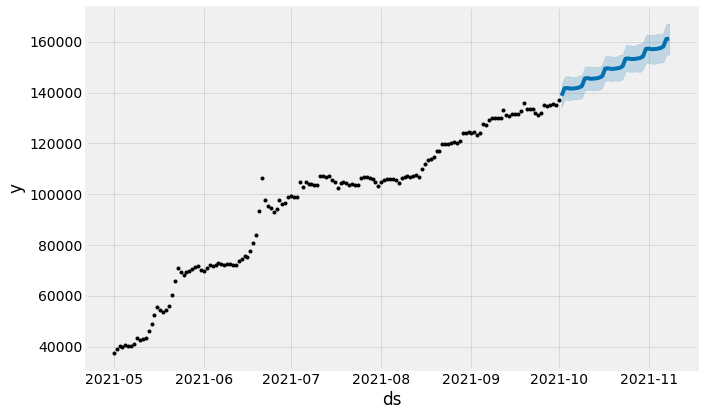

In [27]:
m1.plot(results.reset_index())
plt.show()

###### Prediction using sometimestamps

In [34]:
import import_ipynb
from Utilities import generate_prophet_time_frame

In [45]:
timeframe=generate_prophet_time_frame(start_date="2021/11/04",forecast_steps=30)

In [46]:
timeframe['ds']=timeframe['ds'].apply(lambda x :pd.Period.to_timestamp(x))

In [47]:
m1.predict(timeframe).iloc[0,0]

Timestamp('2021-11-04 00:00:00')

In [48]:
m1.predict(timeframe).iloc[-1,0]

Timestamp('2021-12-03 00:00:00')

In [27]:
timeframe['hamoksha']="hamoksha"

In [19]:
timeframe.dtypes

ds    period[D]
dtype: object

In [30]:
timeframe

,ds,hamoksha
0,2021-11-04,hamoksha
1,2021-11-05,hamoksha
2,2021-11-06,hamoksha
3,2021-11-07,hamoksha
4,2021-11-08,hamoksha
5,2021-11-09,hamoksha
6,2021-11-10,hamoksha
7,2021-11-11,hamoksha
8,2021-11-12,hamoksha
9,2021-11-13,hamoksha


In [31]:
forecast_seperate.columns.values

array(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'], dtype=object)

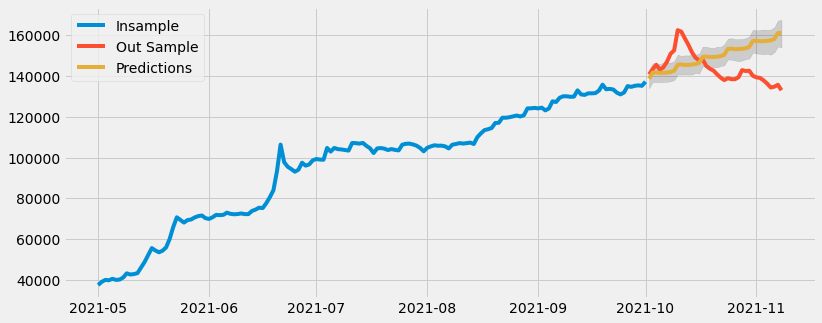

In [15]:
plt.figure(figsize=(12,5))
plt.plot(train['count_players'],label="Insample")
plt.plot(test['count_players'],label="Out Sample")

plt.plot(results['yhat'],label='Predictions')
# predictions=pd.Series(predictions,index=test.index)
# lower_series=pd.Series(ci_lower,index=test.index)
# upper_series=pd.Series(ci_upper,index=test.index)
# plt.plot(predictions,color='green',label='predicted')
plt.fill_between(results.index,results['yhat_lower'],results['yhat_upper'],color='k',alpha=0.15)
plt.legend()
plt.show()

In [16]:
def return_metrics(actual_y,predicted_y):
    print(f'R Squared: {metrics.r2_score(actual_y, predicted_y)}')
    print('Mean Absolute Error:', metrics.mean_absolute_error(actual_y, predicted_y))  
    print('Mean Squared Error: {}'.format(metrics.mean_squared_error(actual_y, predicted_y)))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(actual_y, predicted_y)))

In [17]:
return_metrics(test['count_players'],results['yhat'])

R Squared: -2.5794477017843795
Mean Absolute Error: 11488.474174876392
Mean Squared Error: 184455449.11516047
Root Mean Squared Error: 13581.437667462178


## Prophet Hyperparameter tuning

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.



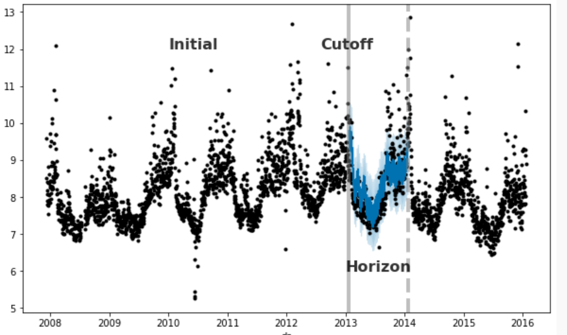

In [18]:
print(len(series))
print(series['ds'].min())
print(series['ds'].max())

154
2021-05-01 00:00:00
2021-10-01 00:00:00


<b>So What happens here is that Prophet starts from the end</b> <br>
<UL>

<LI>Substracts last date by horizon , (This will be the last cut-off) </LI>
<LI>Proceeds backwards to find other cut-offs (if no period is specified) cut-off will be apart by 0.5 * horizon </LI> 
<LI>This makes the initial training just optional as if no specified , will be 3 * horizon </LI>

In [19]:
#cross_validation(m1, initial='50 days',period='30 days', horizon = '30 days')
m1=Prophet()
m1.fit(series)
# df_cv = cross_validation(m1, horizon = f"{len(test)} days")

df_cv = cross_validation(m1, horizon = "15 days")
df_cv.head()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2021-06-18 00:00:00 and 2021-09-16 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-06-19,77602.212047,75604.901507,79792.364641,84051,2021-06-18
1,2021-06-20,79158.418457,77049.479713,81187.397564,93466,2021-06-18
2,2021-06-21,78149.566537,76116.789054,80281.344509,106400,2021-06-18
3,2021-06-22,77352.497365,75326.623306,79535.120363,97784,2021-06-18
4,2021-06-23,77563.130679,75363.518923,79801.934771,95524,2021-06-18


In [20]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
190,2021-09-27,142122.710796,137853.439057,146597.219992,134714,2021-09-16
191,2021-09-28,141911.776231,137354.461479,146434.713130,135228,2021-09-16
192,2021-09-29,142087.360182,137711.373128,146618.940920,135447,2021-09-16
193,2021-09-30,142428.644236,137712.614493,146946.732986,135226,2021-09-16
194,2021-10-01,142810.104525,138119.117879,147672.821977,137247,2021-09-16


<b>Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots

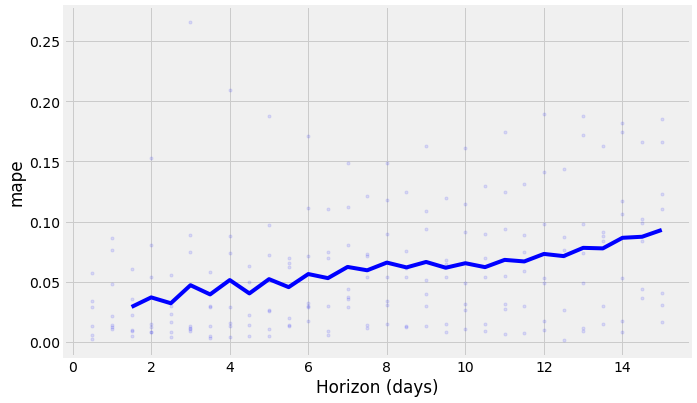

In [21]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


<b>The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was) <br> <br> These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [24]:
from prophet.diagnostics import performance_metrics
#Rolling window takes values ranging from 0.... to 1 (100%)
df_p = performance_metrics(df_cv,rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,15 days,7.376587e+07,8588.70614,6688.826885,0.060838,0.049388,0.061505,0.482051


In [25]:
df_p['mape'].mean()

0.06083837783677805

#### Using Prophet cross validation to tune two parameters

In [26]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(series)  # Fit model with given params
    df_cv = cross_validation(m,  horizon = '15 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2021-06-18 00:00:00 and 2021-09-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000194E29116D0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2021-06-18 00:00:00 and 2021-09-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000194E2917F40>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  12471.347636
1                     0.001                     0.10  12417.313862
2                     0.001                     1.00  11375.661138
3                     0.001                    10.00  12592.715566
4                     0.010                     0.01  10368.957130
5                     0.010                     0.10  10375.176208
6                     0.010                     1.00  10380.745681
7                     0.010                    10.00  10328.131623
8                     0.100                     0.01   9317.405459
9                     0.100                     0.10   9176.357828
10                    0.100                     1.00   9152.490853
11                    0.100                    10.00   9306.025280
12                    0.500                     0.01   8519.793978
13                    0.500                     0.10   8587.89

In [ ]:
tuning_results.iloc[6]['rmse']

In [27]:
# Python
best_params = all_params[np.argmin(rmses)]
best_rmse=tuning_results.iloc[np.argmin(rmses)]['rmse']
print("Best Params are ",best_params)
print("Best RMSE is ",best_rmse)

Best Params are  {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
Best RMSE is  8519.793978206282


In [28]:
m1=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale'], seasonality_prior_scale=  best_params['seasonality_prior_scale'])
m1.fit(series)
future=m1.make_future_dataframe(periods=len(test))
forecast=m1.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
results=forecast[len(series):][['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')

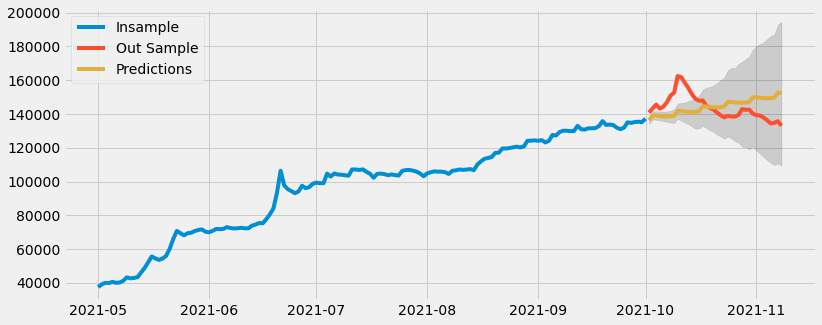

In [30]:
plt.figure(figsize=(12,5))
plt.plot(train['count_players'],label="Insample")
plt.plot(test['count_players'],label="Out Sample")

plt.plot(results['yhat'],label='Predictions')
# predictions=pd.Series(predictions,index=test.index)
# lower_series=pd.Series(ci_lower,index=test.index)
# upper_series=pd.Series(ci_upper,index=test.index)
# plt.plot(predictions,color='green',label='predicted')
plt.fill_between(results.index,results['yhat_lower'],results['yhat_upper'],color='k',alpha=0.15)
plt.legend()
plt.show()

In [32]:
return_metrics(test['count_players'],results['yhat'])

R Squared: -1.1410159680113674
Mean Absolute Error: 8999.264299468172
Mean Squared Error: 110330446.15944393
Root Mean Squared Error: 10503.830070952401


In [38]:
# results.to_csv("predictions.csv")

# Arima

In [33]:
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
# def forecast_accuracy(forecast, actual):
#     '''This function Takes forecasted and actual series and returns the RMSE error
#     The inputs can be lists , series '''
#     rmse=np.mean((forecast - actual)**2)**.5 
    
#     return rmse

##### Using Auto Arima 

In [40]:
arima_model=auto_arima(train['count_players'],start_p=0,d=None,start_q=0,
                      max_p=8,max_d=2,max_q=8,
                       start_Q=0,max_Q=8,
                       start_P=0,max_P=8,m=7, max_D=4,D=None,
                       seasonal=True,supress_warnings=True,n_fits=50,out_of_sample_size=35 )

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  154
Model:             SARIMAX(1, 1, 0)x(3, 0, 0, 7)   Log Likelihood               -1379.246
Date:                           Sun, 12 Dec 2021   AIC                           2770.492
Time:                                   17:18:05   BIC                           2788.675
Sample:                                        0   HQIC                          2777.878
                                           - 154                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    569.7198    352.405      1.617      0.106    -120.981    1260.421
ar.L1          0.0519      0.044      1.183      0.237      -0.034       0.138
ar.S.L7        0.0632      0.058      1.099      0.272      -0.050       0.176
ar.S.L14       0.0741      0.080      0.924      0.356      -0.083       0.231
ar.S.L21       0.1299      0.118      1.101      0.271      -0.101       0.361
sigma2      4.896e+06   2.88e+05     16.993      0.000    4.33e+06    5.46e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              1376.37
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### Using the model fitted on the whole test window(especially if the test size is small)

In [41]:
order=arima_model.order
seasonal_order=arima_model.seasonal_order

model=sm.tsa.statespace.SARIMAX(train['count_players'],order=order,seasonal_order=seasonal_order,trend='c')
model_ARIMA = model.fit()

C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [42]:
predictions_values=model_ARIMA.get_forecast(steps=len(test)).predicted_mean
predictions=pd.Series(predictions_values,index=test.index)

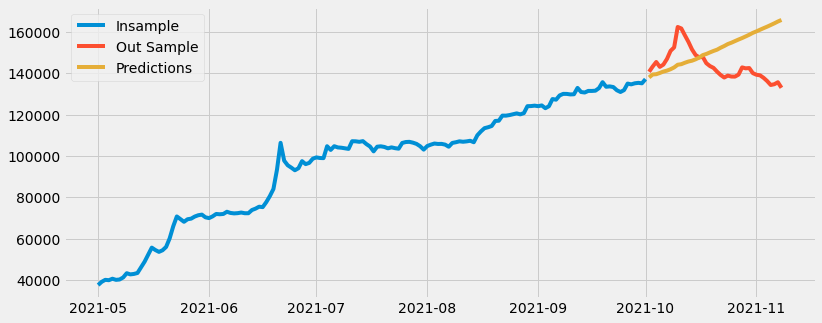

In [45]:
plt.figure(figsize=(12,5))
plt.plot(train['count_players'],label="Insample")
plt.plot(test['count_players'],label="Out Sample")



plt.plot(predictions,label='Predictions')
# predictions=pd.Series(predictions,index=test.index)
# lower_series=pd.Series(ci_lower,index=test.index)
# upper_series=pd.Series(ci_upper,index=test.index)
# plt.plot(predictions,color='green',label='predicted')
# plt.fill_between(results.index,results['yhat_lower'],results['yhat_upper'],color='k',alpha=0.15)
plt.legend()
plt.show()

In [46]:
return_metrics(test['count_players'],predictions_values)

R Squared: -4.0522296288067485
Mean Absolute Error: 13518.838365870557
Mean Squared Error: 260350579.99308243
Root Mean Squared Error: 16135.382858583878


###### Using rolling forecast

In [47]:
def forecast_accuracy(forecast, actual):
    '''This function Takes forecasted and actual series and returns the RMSE error
    The inputs can be lists , series '''
    rmse=np.mean((forecast - actual)**2)**.5 
    
    return rmse

In [48]:
def rolling_forecast_arima_final(train,test,order=(0,1,0),seasonal_order=None,window="sliding",forecast_steps=1,plotting=False):    
    history=train
    predictions=[]
    ci_lower=[]
    ci_upper=[]
    for t in range(0,len(test),forecast_steps):
        if forecast_steps > len(test)-t:
            forecast_steps=len(test)-t
        
        model=sm.tsa.statespace.SARIMAX(history,order=order,seasonal_order=seasonal_order,trend='c')
        model_ARIMA = model.fit()
        
        fc_list=list(model_ARIMA.get_forecast(steps=forecast_steps).predicted_mean.values)
        lower_list=        list(model_ARIMA.get_forecast(steps=forecast_steps,alpha=0.05).conf_int().iloc[:,0].values)
        upper_list=       list(model_ARIMA.get_forecast(steps=forecast_steps,alpha=0.05).conf_int().iloc[:,0].values)
        
        ci_lower=ci_lower + lower_list
        ci_upper=ci_upper + upper_list

        predictions=predictions + fc_list
        obs=test.loc[test.index[t:t+forecast_steps]]
        history=history.append(obs)
        if window=="sliding":
            history=history[forecast_steps:]
        
    if plotting==True:
        plt.figure(figsize=(12,5))
        plt.plot(train,label="Training")
        plt.plot(test,label='original test')
        predictions=pd.Series(predictions,index=test.index)
        lower_series=pd.Series(ci_lower,index=test.index)
        upper_series=pd.Series(ci_upper,index=test.index)
        plt.plot(predictions,color='green',label='predicted')
        plt.fill_between(lower_series.index,lower_series,upper_series,color='k',alpha=0.15)
        plt.legend()
        plt.show()
    
    rmse=forecast_accuracy(predictions,test.values)
    
    return model_ARIMA,predictions,rmse


In [ ]:
model,predictions,rmse_auto=rolling_forecast_arima_final(train,test,order=(0,1,0),seasonal_order=None,window="sliding",forecast_steps=30,plotting=True)
print(rmse_auto)

##### Using Manual hyper parameter tuning to see if results will be different

In [50]:
def evaluate_models(train,validation,p_values,d_values,q_values,P_values,D_values,Q_values,forecast_steps=30,m=7):
    best_score,best_cfg=float("inf"),None    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:                
                            order=(p,d,q) 
                            seasonal_order=(P,D,Q,m)
                            print(order)
                            print(seasonal_order)
                            try :
                                model_ARIMA,predictions,rmse=rolling_forecast_arima_final(train,validation,order=order,seasonal_order=seasonal_order,window="sliding",forecast_steps=forecast_steps,plotting=False)
                                if rmse < best_score:
                                    best_score,best_cfg=rmse,(order,seasonal_order)
                            except Exception:
                                print(Exception)
                                continue
    print(best_score)
    print(best_cfg)

In [51]:
train_actual=train[:round(0.8 * len(train))]
validation=train[round(0.8 * len(train)):]
len(validation) + len(train_actual) + len(test)

192

In [52]:
evaluate_models(train_actual['count_players'],validation['count_players'],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],forecast_steps=30,m=7)

(0, 0, 0)
(0, 0, 0, 7)
(0, 0, 0)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 0, 0)
(0, 1, 0, 7)
(0, 0, 0)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 0, 0)
(1, 0, 0, 7)
(0, 0, 0)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 0, 0)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 0)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 1)
(0, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 1)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 1)
(0, 1, 0, 7)
(0, 0, 1)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 0, 1)
(1, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 1)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 1)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 0, 1)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 0)
(0, 0, 0, 7)
(0, 1, 0)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 1, 0)
(0, 1, 0, 7)
(0, 1, 0)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 0)
(1, 0, 0, 7)
(0, 1, 0)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 1, 0)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 0)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

(0, 1, 1)
(0, 0, 0, 7)
(0, 1, 1)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 1)
(0, 1, 0, 7)
(0, 1, 1)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(0, 1, 1)
(1, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 1)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 1)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(0, 1, 1)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(0, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(0, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(1, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 0)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(0, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

(1, 0, 1)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(0, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(1, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 0, 1)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 0)
(0, 0, 0, 7)
(1, 1, 0)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(1, 1, 0)
(0, 1, 0, 7)
(1, 1, 0)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

(1, 1, 0)
(1, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 0)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 0)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 0)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency i

(1, 1, 1)
(0, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 1)
(0, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 1)
(0, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 1)
(0, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency i

(1, 1, 1)
(1, 0, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 1)
(1, 0, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 1)
(1, 1, 0, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(1, 1, 1)
(1, 1, 1, 7)


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency i

1408.175891327711
((1, 1, 0), (0, 1, 1, 7))


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


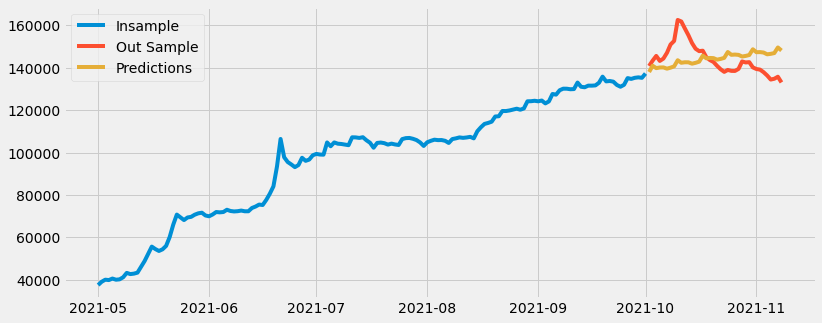

In [53]:
order=arima_model.order
seasonal_order=arima_model.seasonal_order

model=sm.tsa.statespace.SARIMAX(train['count_players'],order=(1,1,0),seasonal_order=(0, 1, 1, 7),trend='c')
model_ARIMA = model.fit()
predictions_values=model_ARIMA.get_forecast(steps=len(test)).predicted_mean
predictions=pd.Series(predictions_values,index=test.index)

plt.figure(figsize=(12,5))
plt.plot(train['count_players'],label="Insample")
plt.plot(test['count_players'],label="Out Sample")


plt.plot(predictions,label='Predictions')
# predictions=pd.Series(predictions,index=test.index)
# lower_series=pd.Series(ci_lower,index=test.index)
# upper_series=pd.Series(ci_upper,index=test.index)
# plt.plot(predictions,color='green',label='predicted')
# plt.fill_between(results.index,results['yhat_lower'],results['yhat_upper'],color='k',alpha=0.15)
plt.legend()
plt.show()

In [59]:
return_metrics(test['count_players'],predictions_values)

R Squared: -0.6113948702090346
Mean Absolute Error: 7720.461382485358
Mean Squared Error: 83038107.90086463
Root Mean Squared Error: 9112.524781906748


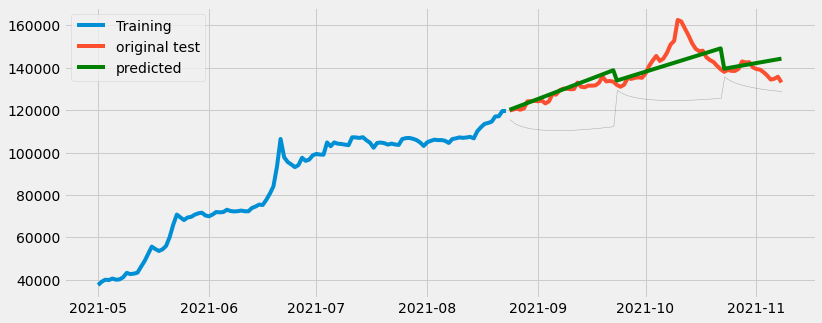

5455.255798671176


In [87]:
# model,predictions,rmse_hypertuning=rolling_forecast_arima_final(train,test,order=(1,1,0),seasonal_order=(0,0,0,7),window="sliding",forecast_steps=30,plotting=True)
# print(rmse_hypertuning)

In [60]:
class predictions_new():
    
    '''
    For reusability
    -Takes data , generates out of sample forecasts for data occuring after the provided date
    -After performing predictions , sets the new timestamp to where predictions stopped 
    '''
    
    def __init__(self,data):
        self.current_time_stamp=data.index[-1]
        self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        self.data=data
        self.predictions_df= pd.Series([])
    
    def forecast(self,model,forecast_steps,plotting=True):
        self.endtimestamp=self.nexttimestamp + timedelta(days = forecast_steps-1)
        out_sample_predictions=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).predicted_mean
        confidence_intervals=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int()
        print("Predicting {} steps ahead".format(forecast_steps))
        if plotting :
            plt.figure(figsize=(12,5))
            plt.plot(self.data,label="insample")
            lower_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
            upper_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()
        
        self.nexttimestamp=self.endtimestamp + timedelta(days = 1)
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
 

#### We want to fit the model to the last observation using the hyper parameters we got 

In [63]:
#fitting the model
model=sm.tsa.statespace.SARIMAX(train.append(test)['count_players'],order=(1,0,0),seasonal_order=(1,1,1,7),trend='c')
model_ARIMA = model.fit()

C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\anaconda3\envs\prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [64]:
predict_instance=predictions_new(train.append(test))

Predicting 30 steps ahead


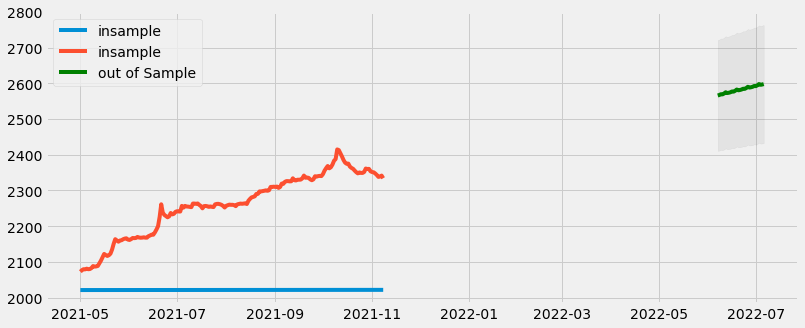

In [72]:
predict_instance.forecast(model_ARIMA,30)

Predicting 30 steps ahead


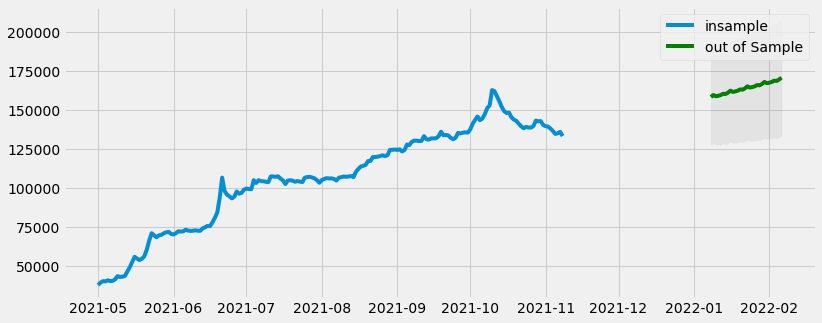

In [286]:
predict_instance.forecast(model_ARIMA,30)

### Generic Class to be used in Pipeline

In [573]:
class predictions:
    
    def __init__(self,data):
        
        #Initially a model and a 
        self.initial_data=data
        self.data=data
        self.incoming=None
        
#         self.current_time_stamp=self.data.index[-1]        
#         self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        self.timestamp_definition(self.data)
        self.model=None
        
        self.predictions_df= pd.Series([])

    def train(self,out_of_sample_size):
        auto_arima_model=auto_arima(self.data[:-1 *out_of_sample_size] ,start_p=0,d=None,start_q=0,
                      max_p=8,max_d=2,max_q=8,
                       start_Q=0,max_Q=8,
                       start_P=0,max_P=8,m=7, max_D=4,D=None,
                       seasonal=True,supress_warnings=True,n_fits=50,out_of_sample_size=out_of_sample_size )
        
        self.model_best_order,self.model_seasonal_order=auto_arima_model.order,auto_arima_model.seasonal_order
        print(f"Order is {self.model_best_order}")
        print(f"Seasonal Order is {self.model_seasonal_order}")

        
        
    def fit(self):
#         model=sm.tsa.statespace.SARIMAX(self.data,order=(1,1,0),seasonal_order=(0,0,0,7),trend='c')
        model=sm.tsa.statespace.SARIMAX(self.data,order=self.model_best_order,seasonal_order=self.model_seasonal_order,trend='c')

        model_ARIMA = model.fit()
        
        self.model=model_ARIMA
        
        self.model_start_timestamp=self.data.index[0] 
        self.model_end_timestamp=self.data.index[-1]
        
    def incoming_new(self,*args):
        
        incoming_series=pd.Series(list(args),pd.date_range(self.nexttimestamp,periods=len(args),freq='D'))
        try :
            self.incoming_all=self.incoming_all.append(incoming_series)
        except :
            self.incoming_all=incoming_series
        
        self.data=self.data.append(incoming_series) 
        self.timestamp_definition(self.data)
        
#         self.current_time_stamp=self.data.index[-1]        
#         self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        
    def reset_incoming(self):
        self.incoming_all=None
        self.data=self.initial_data
        self.timestamp_definition(self.data)
    
    def timestamp_definition(self,data):
        self.current_time_stamp=data.index[-1]        
        self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        
        
   
    def forecast(self,forecast_steps,plotting=False):           
        
        self.endtimestamp=self.nexttimestamp + timedelta(days = forecast_steps-1)      
        
        out_sample_predictions=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).predicted_mean
        confidence_intervals=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int()
        
        lower_series=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
        upper_series=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
        
        '''
        self.nexttimestamp=self.endtimestamp + timedelta(days = 1)
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
        '''
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
    
    
        if plotting:
            plt.figure(figsize=(12,5))
            plt.plot(self.initial_data,label="Original")
            try:
                plt.plot(self.incoming_all,label="incoming")
            except:
                pass
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()
        
       
            

In [751]:
#Generate new instace
continous_predictions=predictions(train.append(test))

In [752]:
continous_predictions.train(30)

Order is (1, 1, 0)
Seasonal Order is (3, 0, 0, 7)


In [753]:
continous_predictions.fit()

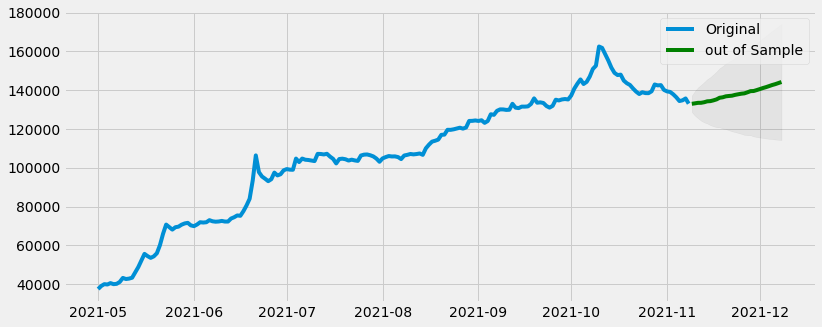

In [754]:
continous_predictions.forecast(30,plotting=True)

In [738]:
#Predict without Fitting 
#Predict with fitting
#Predict with training

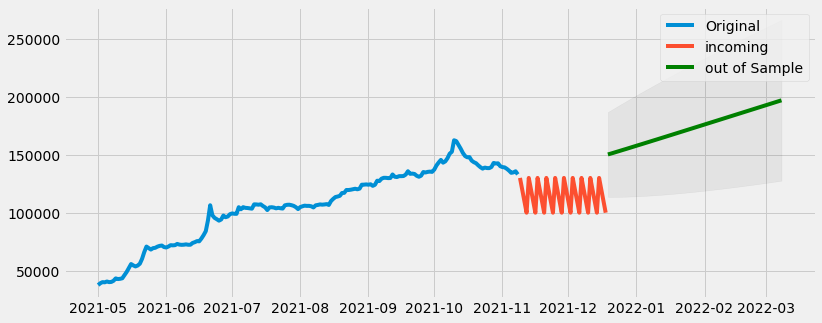

In [764]:
# continous_predictions.reset_incoming()
# continous_predictions.incoming_new(130000,120000,110000,100000,90000,85000,80000,90000,92000,93000,91000,78000)
continous_predictions.incoming_new(130000,120000,110000,100000)
# continous_predictions.incoming_new(125000,140000)

# continous_predictions.train(30)

# continous_predictions.fit()
continous_predictions.forecast(80,plotting=True)

Order is (1, 1, 0)
Seasonal Order is (3, 0, 0, 7)


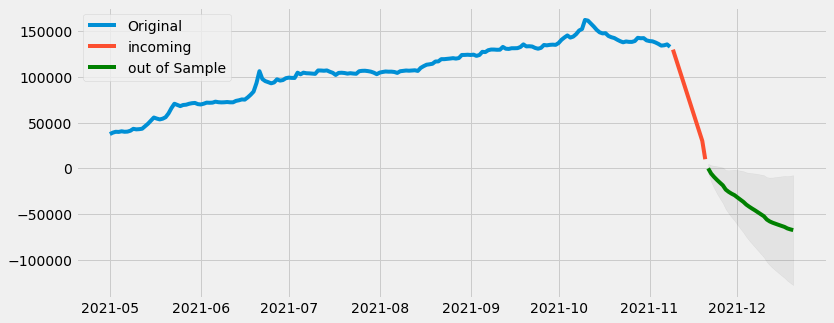

In [732]:
continous_predictions.reset_incoming()
# continous_predictions.incoming_new(125000,140000)
continous_predictions.incoming_new(130000,120000,110000,100000,90000,80000,70000,60000,50000,40000,30000,10000)

continous_predictions.train(40)

continous_predictions.fit()
continous_predictions.forecast(30,plotting=True)

In [ ]:
continous_predictions.reset_incoming()
continous_predictions.incoming_new(130000,120000,110000,100000,90000,85000,80000,90000,92000,93000,91000,78000)

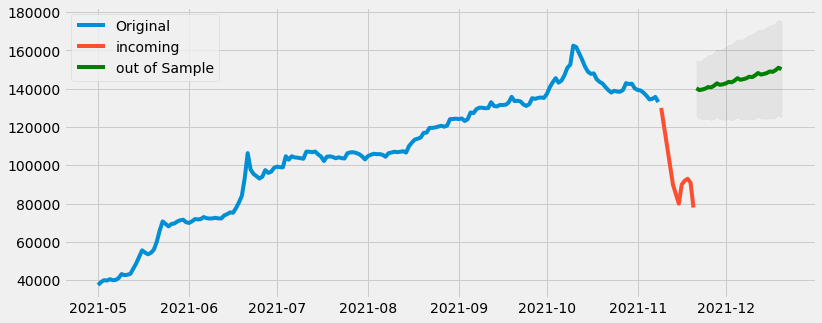

In [455]:
# continous_predictions.forecast(30,plotting=True)

In [543]:
print(continous_predictions.model_start_timestamp)
print(continous_predictions.model_end_timestamp)


2021-05-01 00:00:00
2021-11-16 00:00:00


## Workspace

In [310]:
def add(*args):
    sum=0
    
    for x in args:
        sum=sum + x
    return list(args)

In [311]:
add(4,5,6)

[4, 5, 6]

In [ ]:
class predictions():
    
    '''
    For reusability
    -Takes data , generates out of sample forecasts for data occuring after the provided date
    -After performing predictions , sets the new timestamp to where predictions stopped 
    '''
    
    def __init__(self,trained_data):
        
        self.start_time_stamp=trained_data.index[0]
        self.current_time_stamp=trained_data.index[-1]        
        self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        
        self.initial_trained_data=trained_data
        self.trained_data=trained_data
        self.predictions_df= pd.Series([])
    
    def forecast(self,model,forecast_steps,plotting=True):
        
#         self.endtimestamp=self.nexttimestamp + timedelta(days = forecast_steps-1)
        
        out_sample_predictions=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).predicted_mean
        confidence_intervals=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int()
        
        self.model=model
        
        self.model_train_start_timestamp= self.trained_data.index[0]
        self.model_train_end_timestamp=self.trained_data.index[-1]
        
        
        
        print("Predicting {} steps ahead".format(forecast_steps))
        if plotting :
            plt.figure(figsize=(12,5))
            plt.plot(self.data,label="insample")
            lower_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
            upper_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()y
        
        self.nexttimestamp=self.endtimestamp + timedelta(days = 1)
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
        
    
    def incoming(self,*args):
        
        real_series=pd.Series(list(args),pd.date_range(self.current_time_stamp,periods=len(args),freq='D'))
        
        self.data=self.data.append(real_series)    
        
        self.current_time_stamp=self.current_time_stamp + timedelta(days = len(args))
        
    def retrain_based_on_incoming(self,train=yes,plotting=True):
        if train=yes:
            self.model=sm.tsa.statespace.SARIMAX(self.data,order=model.order,seasonal_order=model.seasonal_order,trend=model.trend)
            
        
        if plotting :
            plt.figure(figsize=(12,5))
            plt.plot(self.initial_data,label="Original data")
#             lower_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
#             upper_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()y
        
        
        
    def plotting():
        
        
           

#         return out_sample_predictions,confidence_intervals
    
     


### LSTM